# Рунге-Кутта

In [ ]:
from numpy  import*
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm,os
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.integrate import odeint
from scipy import linalg
import time
from numpy.linalg import det, inv, svd, norm
import numpy as np

def Runge_Kutta(to, tEnd, yo, tau, f):
          def increment(f, t, y, tau):
                    k1=tau*f(t,y)
                    k2=tau*f(t+(1/4)*tau,y+(1/4)*k1)
                    k3 =tau *f(t+(3/8)*tau,y+(3/32)*k1+(9/32)*k2)
                    k4=tau*f(t+(12/13)*tau,y+(1932/2197)*k1-(7200/2197)*k2+(7296/2197)*k3)
                    k5=tau*f(t+tau,y+(439/216)*k1-8*k2+(3680/513)*k3 -(845/4104)*k4)
                    k6=tau*f(t+(1/2)*tau,y-(8/27)*k1+2*k2-(3544/2565)*k3 +(1859/4104)*k4-(11/40)*k5)
                    #print('ks',k1,k2,k3,k4,k5,k6)
                    return (16/135)*k1+(6656/12825)*k3+(28561/56430)*k4-(9/50)*k5+(2/55)*k6
          y = [yo]
          while True:
            if tau > 0:
              tau = min(tau, tEnd - to)
            else:
              tau = max(tau, tEnd-to)
            to = to + tau
            if to == tEnd:
              break
            yo = yo + increment(f, to, yo, tau)
            y.append(yo)
          return array(y)

# Метод стрельбы

In [ ]:
def shooting(approx, func, left, right, step, params, bc, eps=1e-4):
  steps = 0
  while(True):
        y = np.concatenate((Runge_Kutta((right + left) / 2, left, approx, -step, func)[::-1],
                             Runge_Kutta((right + left) / 2, right, approx, step, func)[1:]))
        #plt.plot(y[:,0])
        ys=y
        residuals = bc(y,params)
        print(f'residuals {steps}', residuals)
        if (np.abs(residuals) < eps).all():
          print('max', max(residuals))
          break
        steps += 1
        F = np.zeros((len(approx), len(approx)))

        for i in range(len(approx)):
            y_approx = approx.copy()
            y_approx[i] += eps
            #print('y_app', y_approx)
            y_i = np.concatenate((Runge_Kutta((right + left) / 2, left, y_approx, -step, func)[::-1],
                                  Runge_Kutta((right + left) / 2, right, y_approx, step, func)[1:]))
            #print('y_i', y_i)
            residuals_i = bc(y_i, params)
            #print('i',residuals_i)
            F[:, i] = (residuals_i - residuals) / eps
        if np.linalg.det(F) == 0:
            print('определитель матрицы фреше равен 0')
            return steps, ys
        approx = approx - np.dot(np.linalg.inv(F), residuals)

        ys = np.concatenate((Runge_Kutta((right + left) / 2, left, approx, -step, func)[::-1],
                      Runge_Kutta((right + left) / 2, right, approx, step, func)[1:]))

  return steps, ys

Напишем функцию для гидры(2 сосуда, 4 уравнения, 2 условия на массу, 2 условия на бернулли)

In [ ]:
def hydra_function(t, y):
  #p_ext = 1.013250
  #R = 0.098   # R_a из записей
  #T = 0.8 # взял период в 1 секунду
  #C = 0.08  #c_a
  #I = 4.64    # I_a
  #V0 = 87  #см**3 из записей
  #heart_delta_p = 0.3

  # средняя скорость крови в крупных сосудах(V') = 20см/c

  # граничные условия(сумма масс и Бернулли)
  # сумма масс: выход из одного сосуда равен входу в другой sum(v') = 0    eps-константа для размерности (пока V0 у всех одинаковая, eps=1)
  # eps1 * f[1] + eps2 * f[3] = 0

  # бернулли:
  #q - плотность
  # moment1 =  y[0]**2/2 + p_k/q     # из записей для 2 сосуда
  # moment2 =  y[2]**2/2 + p_k/q     # из записей для 1 сосуда
  # eps1 * moment1 + eps2 * moment2 = 0

  f = np.zeros(4)
  #y[0] = V_1
  #y[1] = V_1'
  #y[2] = V_2
  #y[3] = V_2'

  # пусть первый сосуд - сердце
  c1 = 0.2
  c2 = 0.25
  r1 = 0.25
  r2 = 0.3
  #I = 0.00003
  I = 4.64
  p_ext = 0.001
  T = 2.1
  V0=87
  #print('a',-r1*T/I)
  #print('b', T**2/(c2*I))
  #print('c', T**2*p_ext/(I*V0))

  f[0] = y[1]                                                 # первая производная V для 1 сосуда

  f[1] = -r1*T/I*y[1] - T**2/(c1*I)*y[0] + T**2*p_ext/(I*V0)   # 2 производная V для 1 сосуда

  f[2] = y[3]                                                 # первая производная V для 2 сосуда

  f[3] = -r2*T/I*y[3] - T**2/(c2*I)*y[2] + T**2*p_ext/(I*V0)   # 2 производная V для 2 сосуда

  #print('y', y)
  #print('f',f)
  return f

In [ ]:
def initial_checker_for_hydra(y_all, bc_params):
  left = y_all[0]
  right = y_all[-1]
  eps1 = 1
  eps2 = 0.5
  p_k = 0.1
  q = 0.1
  heart_delta_p = 0.3  # число из головы
  # eps1 и eps2 - коэффициенты, размера сосуда(чтобы скорость поток считалась одинаково)

  residuals = []


  # ВАЖНО (тут наработки Виты)                                                  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  p_ext = 0
  c1 =0.2
  c2=0.25
  s1=265 
  s2=300

  # Сохранение масс
  residuals.append(2650*right[1] - 3000*left[3])
  residuals.append(2650*left[1] - 3000*right[3])

  # Бернулли
  residuals.append((2650*right[1] / sqrt(2)/2.1/s1)**2 + right[0]/c1 - (3000*left[3]/sqrt(2)/2.1/s2)**2 - left[2]/c2)
  residuals.append((2650*left[1] / sqrt(2)/2.1/s1)**2 + left[0]/c1 - (3000*right[3]/sqrt(2)/2.1/s2)**2 - right[2]/c2 - p_ext)

  return np.array(residuals)

In [ ]:
# В init записываем граничные условия
# init = [сумма масс1, Бернулли1, сумма масс2, Бернулли2]
# первые 2 точки в начале, 3 и 4 в конце

params = []
approx = [0, 0, 0, 0]
step = 0.01
steps, y= shooting(approx, hydra_function,
                   left = 0, right = 1 + step, step = step,
                   params=params, bc = initial_checker_for_hydra)
print('num_steps ', steps)

y [ 1.25875410e-06 -4.57128628e-06  1.28932029e-06 -4.79829112e-06]
y [1.21310864e-06 4.31985290e-06 1.23318192e-06 4.48335615e-06]
residuals 0 [ 2.58424835e-02 -2.55639771e-02  9.08212579e-07  1.36105183e-06]
y [ 2.29857435e-06 -3.64948565e-10  2.87362221e-06  5.93203204e-10]
y [ 2.29886435e-06  6.71550797e-10  2.87380905e-06 -3.22371233e-10]
residuals 1 [ 2.09659713e-17  8.19758486e-18 -1.67077672e-10 -2.36445796e-09]
max 2.0965971268675256e-17
num_steps  1


[ 2.29857435e-06 -3.64948565e-10  2.87362221e-06  5.93203204e-10]
[ 2.29886435e-06  6.71550797e-10  2.87380905e-06 -3.22371233e-10]
[-2.90005329e-10 -1.03649936e-09 -1.86838410e-10  9.15574437e-10]


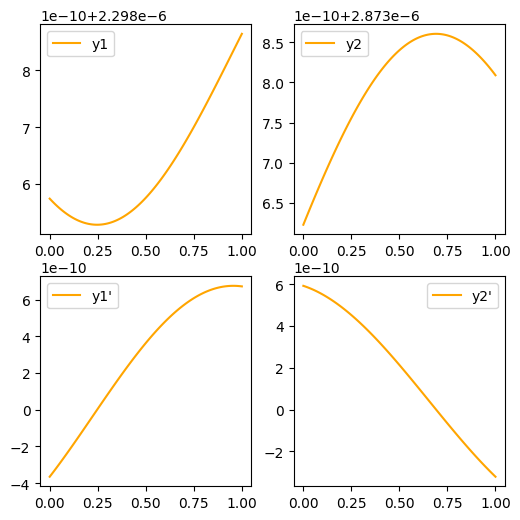

In [ ]:
x = np.arange(0,1 + step,step)
print(y[0])
print(y[-1])
print(y[0] - y[-1])
fig, ax = plt.subplots(2,2,figsize=(6, 6))
ax[0][0].plot(x, y[:,0], c='orange', label='y1')
ax[0][1].plot(x, y[:,2], c='orange',label='y2')
ax[1][0].plot(x, y[:,1], c='orange', label="y1'")
ax[1][1].plot(x, y[:,3], c='orange', label="y2'")
ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()
plt.show()
#print(y)

In [ ]:
plt.plot(y[:,0])
print(y[0][0])
print(y[0][0]/(y[0][0] - y[-1][0]))

In [ ]:
p_ext = 1.013250
R = 0.098   # R_a из записей
T = 1 # взял период в 1 секунду
C = 0.000014  #c_a
I = 4.64    # I_a
V0 = 87  #см**3 из записей
heart_delta_p = 0.3

print('a', -R*T/I)
print('b', -T**2/C/I)
print('c',T**2 * p_ext/I/V0)

Аналитическое решение

In [ ]:
a = -R*T/I
b = -T**2/C/I
c = T**2*p_ext/I/V0

x = np.arange(0,1 + step,step)

if b > -(a**2)/4:
  # y1 = C1*e^(lambda1*x) + C2*e^(lambda2*x)
  # y2 = C3*e^(lambda1*x) + C4*e^(lambda2*x)


if b < -(a**2)/4:
  # y1 = e^(alpha*x) * (C1*cos(beta*x) + C2*sin(beta*x))
  # y2 = e^(alpha*x) * (C3*cos(beta*x) + C4*sin(beta*x))

# y1' = y2'
# y1[0] = y1_0
# moment1 =
# moment2 =
# momoent1 = momoent2
# y2[0] = y2_0


In [ ]:
'''def initial_checker_for_hydra(y_all, bc_params):
  y_try1 = y_all[0]
  y_try2 = y_all[-1]
  y = y_all[0]
  #y = np.concatenate((y_all[-1][:2], y_all[0][2:])     # возможно так
  eps1 = 1
  eps2 = 0.5
  p_k = 0.1
  q = 0.1
  heart_delta_p = 0.3  # число из головы
  # eps1 и eps2 - коэффициенты, размера сосуда(чтобы скорость поток считалась одинаково)
    for i, ves in enumerate(Graph):
        V_i = right[i][0]
        Q_i = right[i][1]
        moment_i = Q_i**2 / 2 / Sq[i]**2 + V_i / Ext[i] / ro

        for to in ves:
            V_to = left[to][0]
            Q_to = left[to][1]

            # mass
            V_i -= V_to

            # momentum
            moment_i -= Q_to**2 / 2 / Sq[to]**2 + V_to / Ext[to] / ro

        err += [V_i, moment_i]
  return np.array(residuals)
  '''

In [ ]:

# Граф
Graph = [[1], [2], [3], [4], [0]]

avg_normal_params = np.array([[7, 12.5, 12.5, 2.025, 2.025],
                              [510.55, 98.15, 631.85, 166.9, 166.9], 
                              [0.0215, 0.07, 0.06, 0.15, 0.27]])

full_ranges = np.array([[[3, 10], [3, 21], [3, 21], [0, 15], [0, 15]], 
                        [[78.5, 1590.4], [0.5, 491], [0.5, 3849], [0.5, 1257], [0, 1591]],
                        [[0, 0.1], [0, 0.5], [0, 0.5], [0, 0.6], [0, 0.6]]])

def dV(Q):
    return Q


def dQ(V, Q, R=10, I=0.0003, C=10):
    return -Q * R / I - V / I / C


def system_i(t, var, i, Res, Ext):
    V, Q = var
    R, I, C = Res[i], 0.1, Ext[i]
    
    return np.array([dV(Q), dQ(V, Q, R, I, C)])

def full_system(t, var, params=avg_normal_params):
    Res, Sq, Ext = params
    res = []
    #print('var', var)
    for i in range(0, len(var), 2):
        v = var[i:i+2]
        #print('v', v)
        res.append(system_i(t, v, i // 2, Res, Ext))
        
    return np.array(res).flatten()

def error(left, right,
          params=avg_normal_params,
          ro=1.05):
    """
    1. Mass conservation
    2. Momentum conservation
    """
    Res, Sq, Ext = params
    left = left.reshape((len(Graph), -1))
    right = right.reshape((len(Graph), -1))
    err = []

    for i, ves in enumerate(Graph):
        V_i = right[i][0]
        Q_i = right[i][1]
        moment_i = Q_i**2 / 2 / Sq[i]**2 + V_i / Ext[i] / ro

        for to in ves:
            V_to = left[to][0]
            Q_to = left[to][1]

            # mass
            V_i -= V_to

            # momentum
            moment_i -= Q_to**2 / 2 / Sq[to]**2 + V_to / Ext[to] / ro

        err += [V_i, moment_i]

    return np.array(err)    

In [ ]:
init = [0]
approx = np.zeros(len(Graph * 2)) #[0, 0, 0, 0, 0]
step = 0.01
steps, y= shooting(approx, full_system, 0, 1 + step, step, init, 1e-5, error)
print('num_steps ', steps)


In [ ]:
import numpy as np
def shoot(t0, t1, 
          y_init = np.random.uniform(1, 5, len(Graph)*2),
          system = full_system,
          params = avg_normal_params,
          solver = Runge_Kutta,
          error = error,
          delta = 10**(-4),
          debug = False,
          step=0.001):

    t = (t1 - t0) / 2
    yt = y_init.copy()
    
    eps = 10**(-4)
    
    cnt = 0
    while True:
        
        left = solver(t, t0, yt, system, -step)
        right = solver(t, t1, yt, system, step)
        err = error(left, right, params)
        
        # Converged
        if np.all(abs(err) < delta):
            cnt += 1
            print(f'Converged in {cnt} iterations', end='')
            break
        
        # find Jacobian and its determinant
        J = np.empty((len(err), len(yt)))
        for i in range(len(yt)):
            yi = yt.copy()
            yi[i] += eps
            
            left = solver(t, t0, yi, system, -step)
            right = solver(t, t1, yi, system, step)
            res = error(left, right, params)
            
            J[:, i] = (res - err) / eps
        
        D = det(J)
        
        print('J', J)

        # Critical point
        if abs(D) < 10**(-10):
            cnt += 1
            print(f'Critical point found in {cnt} iterations | Error = {np.round(err, 3)}')
            break
        
        # Update yt and calculate new error 
        yt -= np.dot(np.linalg.inv(J),  err)
        
    
        # Iteration limit exceeded
        cnt += 1
        if cnt == 30:
            return np.nan

        if debug:
            print(cnt, D)
            
    D = round(D, 4)

    if debug:
        return cnt, yt, D
    
    return D
   

In [ ]:
shoot(0,1)